In [1]:
# Si no se tiene el nuevo dataSet con el  tamaño modificado poner este parametro a True
generarDataSet = False
relacion_aspecto =  True
fondo_totalmente_negro = True

<h1> Preparacion y manipulacion del DataSet </h1>

El data set se organiza en 3 carpetas (train, test, val). Cada carpetas contiene los 4 tipos de clases(NORMAL,CNV,DE,DRUSEN). Haciendo un total de 84.495 imagenes en JPEG.

Cada imagen tiene en su nombre una 'id' aleatoria correspondiente a un paciente anonimo, concatenado con el numero de imagen de ese mismo paciente y la clase, quedando como resultado (CLASE-ID-Nº image). Usaremos un tamaño de fotos de 224*224 con 3 canales.

<h1> Librerias </h1>

In [2]:
import os
import sys
import math
import random
import cv2 as cv2         # Necesitas installar pip install  opencv-python
import itertools
import numpy as np
import dask.dataframe as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import glob

# permite modificar ciertos aspectos-
from IPython.display import clear_output

<h1> Definicion de variables y directorios </h1>
<ul>
    <li> <b> dir_CSV </b> : Directorio padre donde se encentran los csv. </li>
    <li> <b> old_dat  </b> : Directorio donde se encuentran todo el conjunto de datos distribudos segun su clase (Sin modificar su tamaño).
    </li>
    <li> <b> new_dat  </b> : Directorio donde se encuentran todo el conjunto de datos distribudos segun su clase (tamaño modificado). </li>
    <li> <b> new_dat_B  </b> : Directorio donde se encuentran todo el conjunto de datos distribudos segun su clase (tamaño modificado y que serve solo para la clasificacion binaria). </li>
    <li> <b> disTr </b>       : Indica en porcentaje el volumen de datos que tendra cada fase de entrenamiento, validacion y test. </li>
    <li> <b> NCSV </b>        :  Lugar donde almacenaremos los csv con la distribucion de los datos(El sufijo _BI indica que estos datos estan preparados para una clasificaicon binaria, clase enfermo frente a sanos). </li>
    <li> <b> Clases </b>        :  Nombre de las clases. </li>
    <li> <b> Clases_BI </b>        :  Nombre de las distintas clases con una distribucion binaria de los datos. </li>

In [3]:
dir_CSV   = '../DirDataSet/'
old_dat   = [ "../datasetOriginal/CNV","../datasetOriginal/DME","../datasetOriginal/DRUSEN","../datasetOriginal/NORMAL" ]
new_dat   = ["../NewDataset/CNV","../NewDataset/DME","../NewDataset/DRUSEN","../NewDataset/NORMAL"]
new_dat_B =[["../NewDataset/CNV","../NewDataset/DME","../NewDataset/DRUSEN"],["../NewDataset/NORMAL"]]
disTr     = [0.90, 0.05, 0.05]
NCSV      = [ dir_CSV + "ENT.csv",  dir_CSV + "VAL.csv",  dir_CSV + "TEST.csv", dir_CSV + "ENT_BI.csv",  dir_CSV + "VAL_BI.csv",  dir_CSV + "TEST_BI.csv"]
Clases    = ['CNV','DME','DRUSEN','NORMAL']
Clases_BI = ["Enfermos","Sano"]

Size_Fotos = 224
TAMAÑO = (Size_Fotos, Size_Fotos, 3)


<h2> Analisis del histograma y posibles modificaciones </h2>
Las imagenes antes de introducirlas a la red requiere que le hagamos ciertas modificaciones, una de ellas es ajustar el tamaño de todas para que compartan el mismo. Lo mas importante en estos casos es que la manipulacion de las mismas no afecte a la informacion real que contiene, por lo tanto una medida importate que tomar es simpre procurar mantener la relacion de aspecto para no deformar la image.

Para conseguir dicho objetivo se ha realizado una serie de experiemnto con una serie de funciones de tensorflow, pasando un resize normal hasta la utilizacion de un resize con encuadre.
Lo que opservamos mas adelante es una comparativa de la imagen original con una foto con resize pero sin respetar la relacion de aspecto(en fotos con mañor diferencia entre la anchura y la altura se nota mas como en el primer ejemplo), la siguiente es usando la opcion de 'perservar el radio' que nos intentara mantener esa relacion pero sin tener un tamaño idoneo(Es decir nos falta columnas o filas) y por ultimo usando el 'resize_with_pad' que nos permite encuadrar la imagen en un fondo negro. Esto nos permite solucionar dos problemas, el primero es que mantenemos la imagen como esta sin interferir y la segunda es que el tamaño es el mismo 224*224 el sistema ha insertado columnas o filas pertienetes en negro para mantener el tamaño.

Se ha sumado a una funcion que nos permite elimnar manchas blancas de los margenes de la foto(ver el 2 ejemplo), simplemento vemos que pixeles superar un umbrar de brillo y a estos mismos pixeles los ponemos a 0, esto evitara zonas blancas muy grandes.

<h3> Muestra_ref </h3>
Funcion que nos permite ver ejemplos de las diferentes formas en la que podemos realizar  una reduccion del tamaño de las imagenes.
<ul>
    <li>
        img: Una imagen de ejemplo.
    </li>
</ul>

In [4]:
def muestra_ref(img):
    img           = tf.image.decode_jpeg(Muestra, channels=3)
    ORI           = tf.image.convert_image_dtype(img, tf.float32)
    Sin_RE_ASP    = tf.image.resize(ORI, [Size_Fotos,Size_Fotos], preserve_aspect_ratio=False, method=tf.image.ResizeMethod.BILINEAR)
    Con_RE_ASP    = tf.image.resize(ORI, [Size_Fotos,Size_Fotos], preserve_aspect_ratio=True, method=tf.image.ResizeMethod.BILINEAR)
    ENC           = tf.image.resize_with_pad(ORI, Size_Fotos,Size_Fotos,antialias=False , method=tf.image.ResizeMethod.BILINEAR )

    ENC_G = tf.image.rgb_to_grayscale(ENC,name=None)
    plt.figure(figsize=(10, 10))
    plt.title('HISTOGRAMA')
    plt.hist(ENC_G[...,0], bins = 60,alpha=1, edgecolor = 'black',  linewidth=1)
    plt.grid(True)
    plt.show()
    plt.clf()

    ENC = tf.keras.preprocessing.image.img_to_array(ENC,data_format=None,dtype=None)
    ENC = np.where(ENC_G >= 0.99,0,ENC)


    fig = plt.figure(figsize=(15, 10))
    a = fig.add_subplot(1, 4, 1)
    imgplot = plt.imshow(ORI)
    a.set_title('origin')
    a = fig.add_subplot(1, 4, 2)
    imgplot = plt.imshow(Sin_RE_ASP)
    a.set_title('Sin relacion de aspecto')
    a = fig.add_subplot(1, 4, 3)
    imgplot = plt.imshow(Con_RE_ASP)
    a.set_title('Con relacion de aspecto')
    a = fig.add_subplot(1, 4, 4)
    imgplot = plt.imshow(ENC)
    a.set_title('Encuadre')

    fig.show()


<h2> Ejemplo 1 </h2>

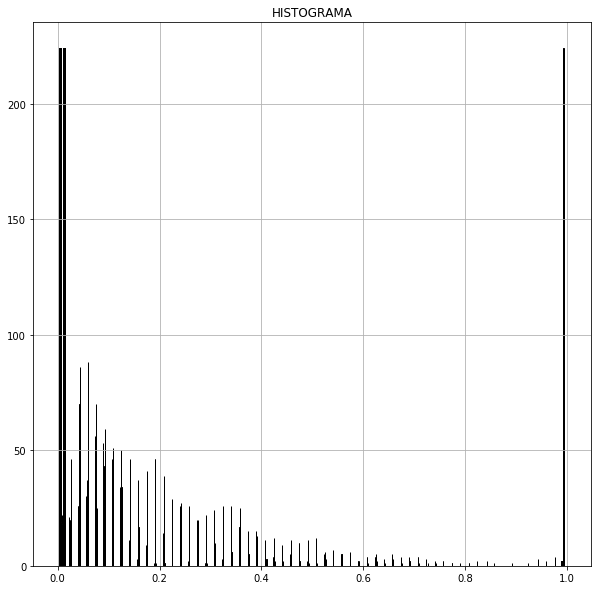

C:\Users\hecto\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

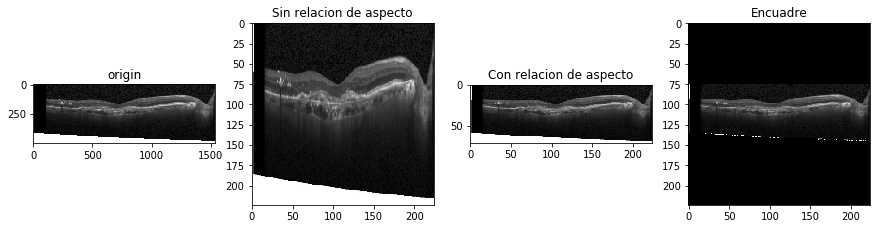

In [5]:
Muestra = tf.io.read_file(str("../datasetOriginal/CNV/CNV-1016042-64.jpeg"))
muestra_ref(Muestra)

<h2> Ejemplo 2 </h2>

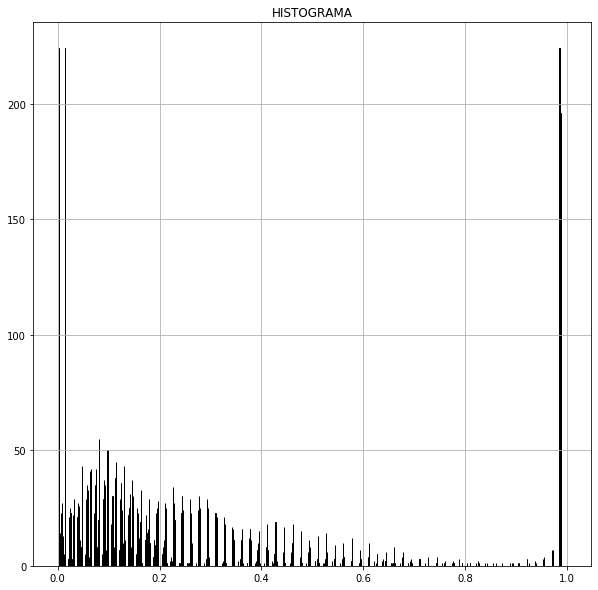

C:\Users\hecto\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

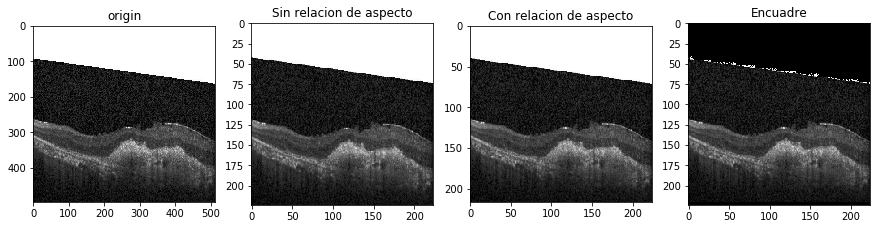

In [6]:
Muestra = tf.io.read_file(str("../datasetOriginal/CNV/CNV-8184974-7.jpeg"))
muestra_ref(Muestra)

<h1> Creaccion Nuevo DataSet </h1>
<ul> <li> Si <b> generarDataSet </b> esta marcado como True el sistema generara y guardara un nuevo dataSet en el siguiente directorio padre <b> "./train_New/" </b> que creara automaticamente.Los csv que se generen optendra los datos de este directorio y no del original. </li> 
    <li> si <b> fondo_totalmente_negro </b> esta a true  se le aplicara una forma de eliminacion de blancos para intentar mejorar la calidad de imagen. Si no se le aplicara solamente un encuadre de la imagen.</ul>

In [7]:
if (generarDataSet):
    # Creacion de un nuevo dataSets.
    directorios  = [x for x in (lent  for lent in ( os.listdir(x) for x in old_dat))]
    tam = sum(len(x) for x in directorios)

    for rutaOriginal, filerClase, newRuta in zip(old_dat, directorios, new_dat):
        for n, name in enumerate(filerClase):
            image_contents = tf.io.read_file(str(rutaOriginal + "/" + name))
            img   = tf.image.decode_jpeg(image_contents, channels=3)
            img   = tf.image.convert_image_dtype(img, tf.float32)

            ENC   = tf.image.resize_with_pad(img, Size_Fotos,Size_Fotos,antialias=False , method=tf.image.ResizeMethod.BILINEAR )

            if(fondo_totalmente_negro):
                # Conversion array.
                ENC   = tf.keras.preprocessing.image.img_to_array(ENC,data_format=None)
                ENC_G = tf.image.rgb_to_grayscale(ENC,name=None)
                ENC   = np.where(ENC_G >= 0.99,0,ENC)
                #ENC   = tf.keras.preprocessing.image.array_to_img(ENC,dtype=None)

            out = tf.image.convert_image_dtype(ENC, tf.uint8)
            out = tf.image.encode_jpeg(out, quality=100)

            fwrite = tf.io.write_file(newRuta+"/" + name, out)
            print("{} ({}:{})".format(name,n,tam))
            clear_output(wait=True)

<h1> Generacion de los csv (Multiclase) </h1>
Nuestro dataSet se encuentra en la ruta contenida en la variable <b> new_dat </b> ya editadas. A continucion precedemos a crear 3 archivos CSV que contendran la ruta del archivo y la clase a la que pertenece la imagen, con el objetivo de distribuir los datos en 3 grupos uno dedicado para suministrar a la red de un dataSet de entrenamiento otro para validar los datos y por ultimo para testearlos.
    Las proporciones del tamaño de los datos son:
    <ul>
        <li> 90% Dedicado al entrenamiento. </li>
        <li> 5%  Validacion </li>
        <li> 5%  Test </li>
    </ul>
    Por supuestos estos porcentages pueden variar segun requeramos, cambiando la variable <b> disTr </b> .

In [8]:
# Optener el numero total de datos de cada clase.
datosENT  = [ [math.trunc(lent * d) for d in disTr]  for lent in ( len( os.listdir(x)) for x in new_dat)]

datosENT[0] = np.array(np.array(datosENT[0]) / 2, dtype=np.int32)
datosExt = datosENT[0]
partittion = np.array(datosENT[0]) / 2

EntrenamientoCSV   = []
EntrenamientoCSV_l = []
ValidacionCSV      = []
ValidacionCSV_l    = []
TestCSV            = []
TestCSV_l          = []
acu = 0


# source, Directorio original de los datos
# DataLen, Numero total de datos por clase.
# datosENT, Distribucion de los datos.

for url, DE , label in zip(new_dat, datosENT, Clases):
    infoD = [url + "/" + x for x in  os.listdir(url)]
    infoL = [label  for z in os.listdir(url)]

    EntrenamientoCSV = np.append(EntrenamientoCSV,infoD[:DE[0]])
    EntrenamientoCSV_l = np.append(EntrenamientoCSV_l, infoL[:DE[0]])

    acu = DE[0]

    ValidacionCSV = np.append(ValidacionCSV,infoD[acu:DE[1] + acu ])
    ValidacionCSV_l = np.append(ValidacionCSV_l, infoL[acu:DE[1] + acu])

    acu = DE[1] + acu

    TestCSV = np.append(TestCSV,infoD[acu:DE[2] + acu])
    TestCSV_l = np.append(TestCSV_l, infoL[acu:DE[2] + acu])

    acu = 0

data = {'filename':EntrenamientoCSV, 'class':EntrenamientoCSV_l }
df = pd.DataFrame(data, columns = ['filename','class'])
df.to_csv(NCSV[0], index=False)

data2 = {'filename':ValidacionCSV, 'class':ValidacionCSV_l }
df = pd.DataFrame(data2, columns = ['filename','class'])
df.to_csv(NCSV[1], index=False)

data3 = {'filename':TestCSV, 'class':TestCSV_l }
df = pd.DataFrame(data3, columns = ['filename','class'])
df.to_csv(NCSV[2], index=False)

Una vez finalizado estos pasos ya tenemos nuestro dataSet para modelos multiclases finalizado.
<h1> Generacion de los csv (biclase o binario) </h1>

In [9]:
# Optener el numero total de datos de cada clase.
datosENT    = [ [  math.trunc(lent * d) for d in disTr]  for lent in (len( os.listdir(x)) for x in new_dat_B[0])]
datosENT_n  = [ [  math.trunc(lent * d) for d in disTr]  for lent in (len( os.listdir(x)) for x in new_dat_B[1])]
datosENT[0] = np.array(np.array(datosENT[0]) / 3, dtype=np.int32)

datosENT = [datosENT] + [np.array(datosENT_n)]

EntrenamientoCSV   = []
EntrenamientoCSV_l = []
ValidacionCSV      = []
ValidacionCSV_l    = []
TestCSV            = []
TestCSV_l          = []
acu = 0

# source, Directorio original de los datos
# DataLen, Numero total de datos por clase.
# datosENT, Distribucion de los datos.

for url, DE , label in zip(new_dat_B, datosENT, Clases_BI):
    infoD = [u + "/" + x for u in url for x in  os.listdir(u) ]
    infoL = [label   for u in url for z in os.listdir(u)]

    for delimi in DE:
        EntrenamientoCSV = np.append(EntrenamientoCSV,infoD[acu:delimi[0] + acu])
        EntrenamientoCSV_l = np.append(EntrenamientoCSV_l, infoL[acu:delimi[0] + acu])

        acu = delimi[0] + acu

        ValidacionCSV = np.append(ValidacionCSV,infoD[acu:delimi[1] + acu ])
        ValidacionCSV_l = np.append(ValidacionCSV_l, infoL[acu:delimi[1] + acu])

        acu = delimi[1] + acu

        TestCSV = np.append(TestCSV,infoD[acu:delimi[2] + acu])
        TestCSV_l = np.append(TestCSV_l, infoL[acu:delimi[2] + acu])

    acu = 0

data = {'filename':EntrenamientoCSV, 'class':EntrenamientoCSV_l }
df = pd.DataFrame(data, columns = ['filename','class'])
df.to_csv(NCSV[3], index=False)

data2 = {'filename':ValidacionCSV, 'class':ValidacionCSV_l }
df = pd.DataFrame(data2, columns = ['filename','class'])
df.to_csv(NCSV[4], index=False)

data3 = {'filename':TestCSV, 'class':TestCSV_l }
df = pd.DataFrame(data3, columns = ['filename','class'])
df.to_csv(NCSV[5], index=False)

# Al finalizar se ha generado 3 ficheros csv que contendran dos columnas, la primera sera la ruta y la segunda 
# indicara a que clase pertenece
# Se llama a la funcion encargada de volcar los datos.
    